# Práctica 1: Métodos simples de Aprendizaje Automático Supervisado.

En primer lugar, implementaremos todas las librerías y paquetes necesarios que se emplearán a lo largo de la práctica.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

El siguiente paso será cargar los datos con los que trabajaremos. En este caso, al encontrarse el archivo "airbnb.csv" en la misma carpeta que el notebook en el que se realiza la práctica, bastará con especificar el nombre y la extensión del mismo como ruta.

In [46]:
file = "airbnb.csv"
data = pd.read_csv(file, sep= ",", header=0)

#Mostramos las primeras filas para comprobar la correcta carga de datos
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


Comprobamos que, efectivamente, el conjunto de datos coincide con el especificado en la actividad. El siguiente paso a realizar consiste en un breve estudio estadístico de los datos numéricos y de la variable "room_type".

In [47]:
#Descripción general de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


In [48]:
#Estudio estadístico de las series de datos numéricos
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


In [49]:
#Para la comprobación del balanceo (o no) de las clases
data['room_type'].value_counts()

room_type
Entire home/apt    7926
Private room       5203
Shared room         192
Name: count, dtype: int64

Estos comandos permiten comprobar: la no existencia de valores nulos, el tipo de valores numéricos con los que se trata, la existencia de datos categóricos y que existe un desbalanceo en las clases bastante evidente. A continuación se procederá a la descategorización de datos categóricos y escalado de los datos numéricos.

In [50]:
# Identificar columnas numéricas y categóricas
columnas_numericas = data.select_dtypes(include=['int64', 'float64']).columns
columnas_categoricas = data.select_dtypes(include=['object']).columns

# Eliminar la columna que contiene las clases
columnas_categoricas = columnas_categoricas.drop('room_type')

# Crear transformers
transformaciones_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

transformaciones_categoricas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear preprocessor
preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformaciones_numericas, columnas_numericas),
        ('cat', transformaciones_categoricas, columnas_categoricas)
    ])

# Aplicar el preprocessor a los datos
datos_preprocesados = preprocesador.fit_transform(data)

## Modelos: entrenamiento y validación.

Una vez que los datos están correctamente descategorizados y escalados, se puede proceder a dividir los datos con el objetivo de entrenar y validar los distintos modelos. En este apartado, se incluirán mecanismos de balanceo de las clases cuando aplique.

In [51]:
# Definir la variable objetivo que contiene las clases
y = data['room_type']

# Dividir los datos en entrenamiento y validación (0.8 y 0.2 respectivamente). Empleamos una semilla (random_state) para poder replicar los datos
x_entreno, x_validacion, y_entreno, y_validacion = train_test_split(datos_preprocesados, y, test_size=0.2, random_state=111)


# Inicializar los clasificadores
clasificador_knn = KNeighborsClassifier(weights='uniform') # Balanceo de clases mediante weights = 'uniform'
clasificador_ad = DecisionTreeClassifier(random_state=111, class_weight='balanced') # Balanceo de clases mediante class_weight = 'balanced'
clasificador_nb = GaussianNB() #En el caso de Naibe Bayes, no se implementa un balanceo de clases por la naturaleza probabilística del algoritmo 

### Naive Bayes

In [52]:
# Ajuste
clasificador_nb.fit(x_entreno.toarray(), y_entreno)

# Predición
prediccion_nb = clasificador_nb.predict(x_validacion.toarray())

# Comprobación de la prediccoón
exactitud_nb = accuracy_score(y_validacion, prediccion_nb)

# Información
print(f"Acc. NB: {exactitud_nb}")

Acc. NB: 0.1380863039399625


### Árboles de Decisión

In [53]:
# Ajuste
clasificador_ad.fit(x_entreno, y_entreno)

# Predición
prediccion_ad = clasificador_ad.predict(x_validacion)

# Comprobación de la prediccoón
exactitud_ad = accuracy_score(y_validacion, prediccion_ad)

# Información
print(f"Acc. DT:{exactitud_ad}")

Acc. DT:0.8555347091932458


### K Nearest Neighbors

In [54]:
# Ajuste
clasificador_knn.fit(x_entreno, y_entreno)

# Predición
prediccion_knn = clasificador_knn.predict(x_validacion)

# Comprobación de la prediccoón
exactitud_knn = accuracy_score(y_validacion, prediccion_knn)

# Información
print(f"Acc. KNN:{exactitud_knn}")

Acc. KNN:0.7729831144465291


Tras la ejecución del código, se puede comprobar que los modelos empleados podrían no ser los mejores para el conjunto de datos. Esto se puede intentar arreglar escogiendo los datos de entreno y validación de una manera distinta o bien ajustanto hiperparámetros. Tal y como especifica la actividad, se probará esto segundo. 

## Ajuste de hiperparámetros y selección de los mejores modelos

### K Nearest Neighbors

In [55]:
# Definir los parámetros a ajustar
parametros_knn = {'n_neighbors': list(range(1, 21))}

# Inicializar GridSearchCV, se buscará el modelo que mayor exactitud proporcione con los hiperparámetros proporcionados
grid_search_knn = GridSearchCV(clasificador_knn, parametros_knn, cv=10, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search_knn.fit(x_entreno, y_entreno)

# Obtener el mejor modelo y sus hiperparámetros
mejor_modelo_knn = grid_search_knn.best_estimator_
mejores_parametros_knn = grid_search_knn.best_params_

# Evaluar el mejor modelo en el conjunto de prueba
pred_knn_optimizado = mejor_modelo_knn.predict(x_validacion)
exactitud_knn_optimizado = accuracy_score(y_validacion, pred_knn_optimizado)

# Imprimir resultados
print("Mejores hiperparámetros para KNN:", mejores_parametros_knn)
print("Exactitud para estos parámetros:", exactitud_knn_optimizado)


Mejores hiperparámetros para KNN: {'n_neighbors': 3}
Exactitud para estos parámetros: 0.7711069418386491


### Árboles de Decisión

In [56]:
# Definir los parámetros a ajustar
parametros_arbol = {
    'max_leaf_nodes': list(range(2, 51)),
    'min_samples_split': list(range(2, 7)),
    'max_depth': list(range(1, 21))
}

# Inicializar GridSearchCV, se buscará el modelo que mayor exactitud proporcione con los hiperparámetros proporcionados
grid_search_tree = GridSearchCV(clasificador_ad, parametros_arbol, cv=10, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search_tree.fit(x_entreno, y_entreno)

# Obtener el mejor modelo y sus hiperparámetros
mejor_modelo_arbol = grid_search_tree.best_estimator_
mejores_parametros_arbol = grid_search_tree.best_params_

# Evaluar el mejor modelo en el conjunto de prueba
pred_arbol_optimizado = mejor_modelo_arbol.predict(x_validacion)
exactitud_arbol_optimizado = accuracy_score(y_validacion, pred_arbol_optimizado)

# Imprimir resultados
print("Mejores hiperparámetros para Árboles de Decisión:", mejores_parametros_arbol)
print("Exactitud para estos parámetros:", exactitud_arbol_optimizado)


Mejores hiperparámetros para Árboles de Decisión: {'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_split': 2}
Exactitud para estos parámetros: 0.8161350844277674


## Gráficos explicativos

En adelante y para obtener una mejor visualización de los resultados mostrados, se mostrarán gráficos que miden la exactitud del modelo de acuerdo a los hiperparámetros empleados en su generación.

### K Nearest Neighbors

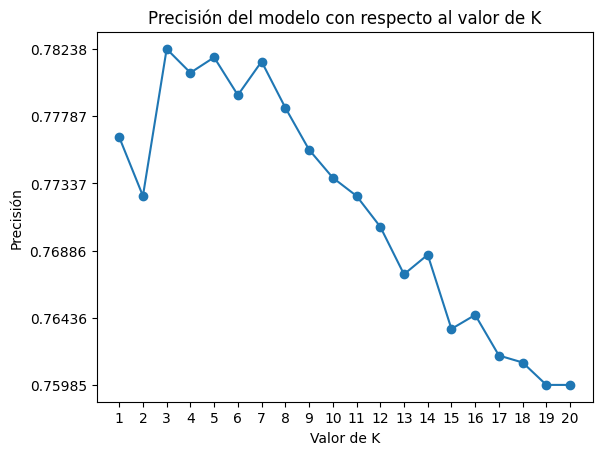

In [57]:
ks = list(grid_search_knn.cv_results_['param_n_neighbors'])
precisiones_knns = list(grid_search_knn.cv_results_['mean_test_score'])

# Por ejemplo, visualizar la precisión en función de los hiperparámetros
plt.figure()

plt.plot(ks, precisiones_knns, marker = 'o')
plt.xticks(ks)
plt.yticks(np.arange(
    min(precisiones_knns)
    , max(precisiones_knns) + (max(precisiones_knns)-min(precisiones_knns))/5 
    , (max(precisiones_knns)-min(precisiones_knns))/5
))
plt.title('Precisión del modelo con respecto al valor de K')
plt.xlabel('Valor de K')
plt.ylabel('Precisión')
plt.show()

### Árboles de Decisión

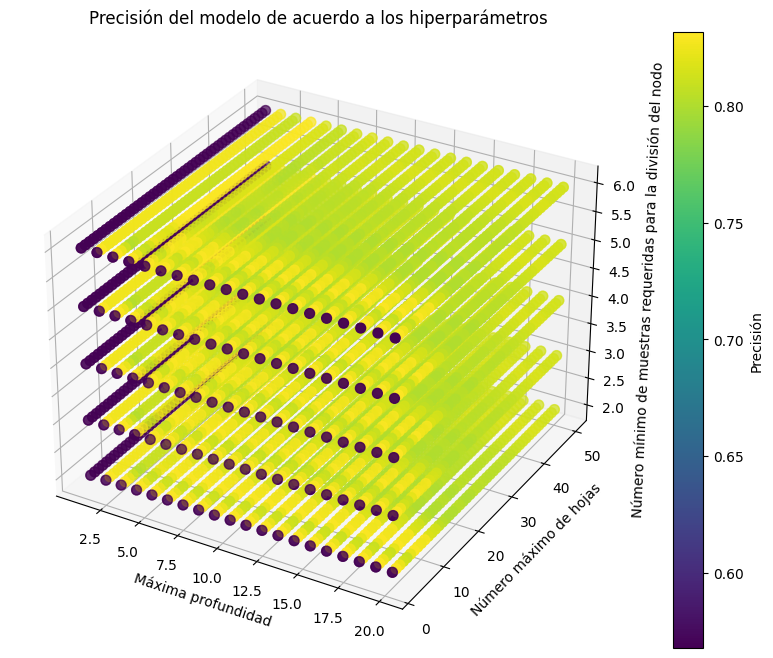

In [77]:
ads_md = list(grid_search_tree.cv_results_['param_max_depth'])
ads_mlf = list(grid_search_tree.cv_results_['param_max_leaf_nodes'])
ads_mss = list(grid_search_tree.cv_results_['param_min_samples_split'])
precisiones_ads = list(grid_search_tree.cv_results_['mean_test_score'])

# Por ejemplo, visualizar la precisión en función de los hiperparámetros
grafica = plt.figure(figsize=(12,8))
ax = grafica.add_subplot(111, projection='3d')

ax.scatter(ads_md, ads_mlf, ads_mss, c=precisiones_ads, cmap='viridis', s=50)
ax.set_xlabel('Máxima profundidad')
ax.set_ylabel('Número máximo de hojas')
ax.set_zlabel('Número mínimo de muestras requeridas para la división del nodo')
ax.set_title('Precisión del modelo de acuerdo a los hiperparámetros')

cbar = grafica.colorbar(ax.scatter(ads_md, ads_mlf, ads_mss, c=precisiones_ads, cmap='viridis', s=50))
cbar.set_label('Precisión')

plt.show()

## Conclusiones

Se concluye que para este caso específico, el modelo Naive Bayes no es un modelo válido. Por otra parte, se observa que tanto K Nearest Neighborgs como Árboles de Decisión presentan, de base, una buena exactitud para el conjunto de datos a trabajar. Ajustando los hiperparámetros de estos últimos, observamos una mejora significativa en la precisión que presentan aunque el valor de precisión mostrado no es el obtenido, esto último se debe a que GridSearchCV divide automáticamente los datos de distintas maneras y el valor de precisión que toma es la media de las precisiones para cada conjunto de datos.

Finalmente, aunque la precisión no es la única métrica que determina la validez del modelo, es una buena primera aproximación a la misma.